# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

Mounted at /content/drive
Label: 1


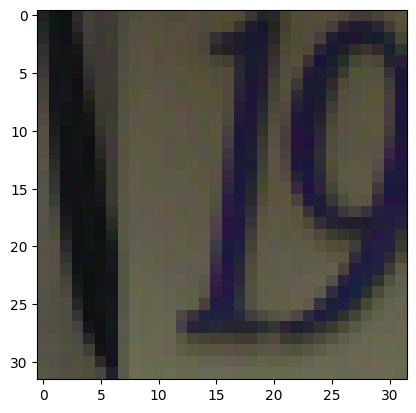

In [ ]:
# Basic example loading images from the svhn dataset
import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
# Mount Google Drive
drive.mount('/content/drive')
data_path= '/content/drive/My Drive/Curs 2022-2023/Deep Learning/P3/Data/'
results_path = '/content/drive/My Drive/Curs 2022-2023/Deep Learning/P3/Results/'

# Load mat file with train images from SVHN
import scipy.io as sio
train_mat = sio.loadmat(data_path + 'svhn/train_32x32.mat')

images = train_mat['X']
labels = train_mat['y'].squeeze()



example_image, example_label = images[:,:,:,0], labels[0] 

print('Label: ' + str(example_label))
plt.imshow(example_image)

# Ex. 1


'''
1. Try to obtain the maximum test accuracy possible in the SVHN dataset. For this purpose train/test different variants of the CNN provided in P3-Part1-Examples.
   You can explore different strategies:
1.1. Increase the size of the network by adding one ore more conv. layers. You can also increase the number of filters in each layer.
1.2. Try different optimizers such as Adam or SGD with momentum and modify the learning rate. You can check: https://pytorch.org/docs/stable/optim.html
1.3. Explore different random transformations during training ( Data augmentation ) such as random cropping with padding. 
You can check: https://pytorch.org/docs/stable/torchvision/transforms.html . Remember that these random transofrmation must not be used during testing.
1.4 Whatever you consider...


2. Save all the different models , compare their test accuracy and analyse the results. Discuss what model has been shown more effective and why have you used the different strategies.
'''

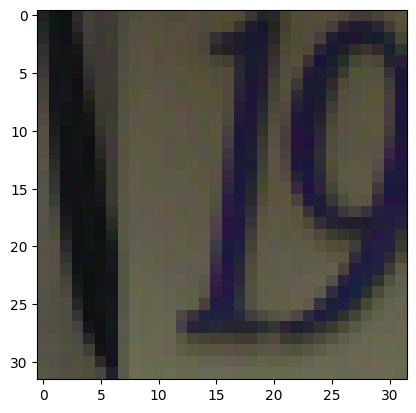

In [ ]:
plt.imshow(example_image)

# Sol. 1

Label: 1


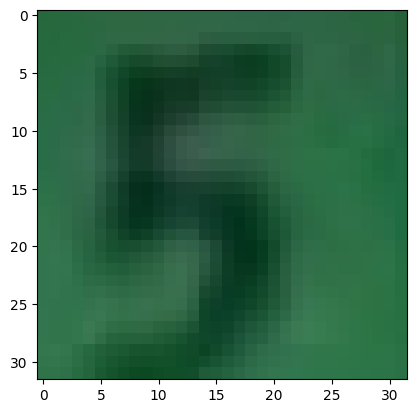

In [ ]:
test_mat = sio.loadmat(data_path + 'svhn/test_32x32.mat')

test_images = test_mat['X']

test_image, test_label = test_images[:,:,:,0], labels[0] 

print('Label: ' + str(test_label))
plt.imshow(test_image)

In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

#Making native class loader
class SVHN(torch.utils.data.Dataset):
    
    def __init__(self, dataDir=data_path+'/svhn/train_32x32.mat', transform=None):
        mat_data = sio.loadmat(dataDir)
        self.data = mat_data['X']
        self.labels = mat_data['y'].squeeze()
        self.transform = transform
        
    def __getitem__(self, index):
        data = self.data[:, :, :, index]  # Assuming the image dimensions are (height, width, channels)
        lbl = self.labels[index]
      
        #data = Image.fromarray(data.transpose((1, 2, 0)))  # Transpose image dimensions for PIL compatibility
        data = Image.fromarray(data, mode='RGB')

        if self.transform is not None:
            data = self.transform(data)
    
        return data, lbl

    def __len__(self):
        return len(self.data)
 


tr = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean = [.5], std = [.5])
        ])

 

In [ ]:
import torchvision.transforms as tf

#Making native class loader
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=256, 
                                               shuffle=True)

In [ ]:
# Define an standard CNN -> Two conv. blocks and linear layer 
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5,  padding=2)
        #input : 1 channel, output 16 channel, filter size : 5x5
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,  padding=1)
        #input : 1 channel, output 16 channel, filter size : 3x3

        self.conv3 = nn.Conv2d(64, 128, kernel_size=7,  padding=3)
        #input : 1 channel, output 16 channel, filter size : 3x3

        self.conv4 = nn.Conv2d(128, 256, kernel_size=1,  padding=0)
        #input : 1 channel, output 16 channel, filter size : 3x3
        
        self.fc = nn.Linear(2*2*256, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        #print(x.shape)
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) #128,32,7,7 -> 128,7*7*32
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        
        return out 



In [ ]:
CNN = ConvNet()
CNN = CNN.cuda()

In [ ]:
# Cross entropy loss for classification problems
criterion = nn.CrossEntropyLoss()

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(CNN.parameters(),lr = learning_rate)
optimizer2 = torch.optim.SGD(CNN.parameters(),lr = learning_rate)

# Device configuration (choose GPU if it is available )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_epochs = 5


In [ ]:
# Train the model
if True :
    SVHNTrain = SVHN(data_path + 'svhn/train_32x32.mat',tr)
    train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=1024, 
                                               shuffle=True)
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    # Save the model checkpoint
    torch.save(CNN.state_dict(), results_path+'/model.ckpt')
    #to load : model.load_state_dict(torch.load(save_name_ori))






In [ ]:
#Load the model
CNN.load_state_dict(torch.load(results_path+'/model.ckpt'))

# Test the model
if True : 
    # Load test dataset
    SVHNTest = SVHN(data_path + 'svhn/test_32x32.mat',tr)
    test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=64, 
                                               shuffle=True)
    CNN.eval() # Set the model in evaluation mode
    
    # Compute testing accuracy
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 88.74462200368777 %


# Ex. 2

# **Building your own efficient Convolutional Network architecture for SVHN**

In the following,  you will need to build your own CNN architecture to predict digit numbers on the SVHN dataset. You are completely free to use any kind of layers and hyper-parameters for this purpose. Your goal is to acheive the maximum possible accuracy on the test set (the better, the higher score you'll get in the exercice). The only constraint is that your model should not contain more than 150K parameters. Below, we provide a simple code to compute the number of parameters in a model.

## Computing model parameters

In [5]:
# Compute model paramters
def compute_model_params(model):
  params = 0
  for p in model.parameters():
    params+= p.numel()
  return params

In [6]:
import torch
import torch.nn as nn

# ResNet style network
class ResSim(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ResSim, self).__init__()
        
        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv21 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.fc = nn.Linear(8*8*64, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out11 = self.relu(self.conv11(x))
        out12 = self.relu(self.conv12(out11)) + out11

        out = self.maxpool(out12)

        out21 = self.relu(self.conv21(out)) 
        out = self.relu(self.conv22(out21)) + out21
        out = self.maxpool(out)
        
        #print(out.shape)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out
# Initialize the model
model = ResSim(num_classes=10)
# Compute and print number of params
n_params = compute_model_params(model)
print("ResNet Parameters: " + str(n_params)) ## 
print("THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!")

ResNet Parameters: 153546
THIS MODEL CONTAINS 153K PARAMS, IT IS CONSIDERED NOT VALID FOR THE EXERCICE!!!!!!


## Sol. 2

### Train your model on SVHN

In [7]:
## Create SVHN database

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
from google.colab import drive
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Curs 2022-2023/Deep Learning/P3/Data'
results_path = '/content/drive/My Drive/Curs 2022-2023/Deep Learning/P3/Results/'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Making native class loader
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

# Create train data loader
tr = tf.Compose([
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])
SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=128, 
                                               shuffle=True)

Mounted at /content/drive


In [8]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name='model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        return 100 * correct / total

In [11]:
#1 High params: 79k Avg accuracy: 94'4%

def conv_dw(in_channels, out_channels, stride=1, padding=1, kernel_size=3, dropout=0.05):
  return nn.Sequential(
      # Normal convolution
      nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False),
      nn.BatchNorm2d(in_channels),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout),

      # Pointwise convolution 
      nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout),
    )


class MobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.05),
            )
        
        self.model = nn.Sequential(
            conv_dw(in_channels = 32, out_channels = 64, stride = 1, padding = 3, kernel_size = 7, dropout = 0.05),
            conv_dw(in_channels = 64, out_channels = 64, stride = 1, padding = 3, kernel_size = 7, dropout = 0.05),
            nn.AvgPool2d(2,2),
            conv_dw(in_channels = 64, out_channels = 128, stride = 1, padding = 2, kernel_size = 5, dropout = 0.05),
            conv_dw(in_channels = 128, out_channels = 128, stride = 1, padding = 2, kernel_size = 5, dropout = 0.05),
            nn.AvgPool2d(2,2),
            conv_dw(in_channels = 128, out_channels = 256, stride = 1, padding = 1, kernel_size = 3, dropout = 0.05),


            nn.AdaptiveAvgPool2d(1) # It adapts the pooling selectiong the output dimension
        )
        self.fc = nn.Linear(256,num_classes)
        

    def forward(self, x):
        x = self.conv0(x)
        x = self.model(x)
        x = x.reshape(x.size(0), -1) 
        x = self.fc(x)
        
        return x

mobile_net_high = MobileNet()

n_params = compute_model_params(mobile_net_high)
print("MobileNet with high amount of parameters: " + str(n_params)) 

MobileNet with high amount of parameters: 81429


In [ ]:
#2 Low params: 32k Avg accuracy: 93'4%

def conv_dw(in_channels, out_channels, stride=1, padding=1, kernel_size=3, dropout=0.05):
  return nn.Sequential(
      nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=False),
      nn.BatchNorm2d(in_channels),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout),

      # Pointwise conv
      nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout),
    )


class MobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv0 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.05),
            )
        self.model = nn.Sequential(
            conv_dw(in_channels = 32, out_channels = 48, stride = 1, padding = 3, kernel_size = 7, dropout = 0.05),
            conv_dw(in_channels = 48, out_channels = 64, stride = 1, padding = 3, kernel_size = 7, dropout = 0.05),
            nn.AvgPool2d(2,2),
            conv_dw(in_channels = 64, out_channels = 96, stride = 1, padding = 2, kernel_size = 5, dropout = 0.05),
            nn.AvgPool2d(2,2),
            conv_dw(in_channels = 96, out_channels = 128, stride = 1, padding = 2, kernel_size = 3, dropout = 0.05),
            nn.AdaptiveAvgPool2d(1)
      
        )
        self.fc = nn.Linear(128,num_classes)
        

    def forward(self, x):
        x = self.conv0(x)
        x = self.model(x)
        x = x.reshape(x.size(0), -1) 
        x = self.fc(x)
        
        return x

mobile_net_low = MobileNet()

n_params = compute_model_params(mobile_net_low)
print("MobileNet low amount of parameters: " + str(n_params)) 

MobileNet Parameters: 32794


### Test your model


In [ ]:
#Train MyModel
my_model = mobile_net_low

n_params = compute_model_params(my_model)
print("MobileNet Parameters: " + str(n_params)) 

#Initialize optimizer 
learning_rate = .1
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate, 
                            weight_decay=1e-5, momentum=0.9)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=10, model_name='my_net.ckpt', device=device)



my_model = MobileNet()

n_params = compute_model_params(my_model)
print("MobileNet Parameters: " + str(n_params)) 

# Show results for all the trained models
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=128, 
                                               shuffle=True)

# Test
my_net = MobileNet()
my_net.load_state_dict(torch.load(results_path + 'my_net.ckpt'))
my_net.cuda()
acc = test(my_net, test_loader)
print('Accuracy MyNet: ' + str(acc))


MobileNet Parameters: 32794
Epoch [1/10], Step [100/573], Loss: 2.0991
Epoch [1/10], Step [200/573], Loss: 1.7547
Epoch [1/10], Step [300/573], Loss: 1.4295
Epoch [1/10], Step [400/573], Loss: 1.2027
Epoch [1/10], Step [500/573], Loss: 1.0521
Epoch [1/10], Step [573/573], Loss: 0.9727
Epoch [2/10], Step [100/573], Loss: 0.3814
Epoch [2/10], Step [200/573], Loss: 0.3673
Epoch [2/10], Step [300/573], Loss: 0.3583
Epoch [2/10], Step [400/573], Loss: 0.3551
Epoch [2/10], Step [500/573], Loss: 0.3491
Epoch [2/10], Step [573/573], Loss: 0.3466
Epoch [3/10], Step [100/573], Loss: 0.3118
Epoch [3/10], Step [200/573], Loss: 0.3004
Epoch [3/10], Step [300/573], Loss: 0.3021
Epoch [3/10], Step [400/573], Loss: 0.2988
Epoch [3/10], Step [500/573], Loss: 0.2958
Epoch [3/10], Step [573/573], Loss: 0.2929
Epoch [4/10], Step [100/573], Loss: 0.2813
Epoch [4/10], Step [200/573], Loss: 0.2734
Epoch [4/10], Step [300/573], Loss: 0.2708
Epoch [4/10], Step [400/573], Loss: 0.2683
Epoch [4/10], Step [500/57

In [ ]:


my_model = MobileNet()

n_params = compute_model_params(my_model)
print("MobileNet Parameters: " + str(n_params)) 

# Show results for all the trained models
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat',tr)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=256, 
                                               shuffle=True)

#
my_net = MobileNet()
my_net.load_state_dict(torch.load(results_path + 'my_net.ckpt'))
my_net.cuda()
acc = test(my_net, test_loader)
print('Accuracy MyNet: ' + str(acc))

MobileNet Parameters: 79754
Accuracy MyNet: 94.06499692685925
